# General function

In [ ]:
def read_json_result(base_path):
  contenido = os.listdir(base_path)
  jsonData = []
  for item in contenido:
    name = base_path + item
    with open(name, 'r') as f:
      data = json.load(f)
      # tupla = (str(item), data)
      jsonData.append(data)

  return jsonData

In [ ]:
def getJsonResponse(document_name, processed_list):
  for item in processed_list:
    if item['document']+".json" == document_name:
      return item

  return None

In [ ]:
def levenshtein_similarity(str1, str2):
    return 1 - Levenshtein.distance(str1, str2) / max(len(str1), len(str2))

def cer(reference, hypothesis):
    return Levenshtein.distance(reference, hypothesis) / len(reference)

def wer(reference, hypothesis):
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    return editdistance.eval(ref_words, hyp_words) / len(ref_words)


In [ ]:
def get_dfmetrics_by_field(ground_truth_list, field_name):

  df = pd.DataFrame()
  dict_result = []
  for gt in ground_truth_list:
    doc_name = gt["document"] + ".json"
    json_processed = getJsonResponse(doc_name, llm_processed_list)
    result = compare_json(gt, json_processed, doc_name,field_name)
    dict_result.append(result)

  df_result = pd.DataFrame(dict_result)
  # df_result = df_result.sort_values(by='file_name', ascending=True)
  return df_result

# Libraries

In [ ]:
!pip install Levenshtein

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 38.5 MB/s eta 0:00:00


In [ ]:
!pip install python-Levenshtein editdistance

In [ ]:
import os
import pandas as pd
import json
import Levenshtein
import editdistance
import matplotlib.pyplot as plt
import seaborn as sns

# Read GroundTruth


In [ ]:
gt_path = "/content/drive/MyDrive/UTEC/Ciclo IV/Tesis II/NGS documentos/Foundation/GroundTruth/"

In [ ]:
ground_truth = read_json_result(gt_path)

In [ ]:
ground_truth_list = []
for json_list in ground_truth:
  for json in json_list:
    ground_truth_list.append(json)

#Read LLM JSON proccessed - output

In [ ]:
import json
base_path = "/content/drive/MyDrive/UTEC/Ciclo IV/Tesis II/NGS documentos/Foundation/JSON/LLMProcessed/"

In [ ]:
llm_processed_list = read_json_result(base_path)

# BIOMARKERS FINDINGS

In [ ]:
gt = ground_truth_list[0]
document_name = gt["document"] + ".json"

print("Document's name: ", document_name)
print("BIOMARKER FINDINGS - GroundTruth")
for i in range(len(gt["Biomakers findings"])):
  print(i+1,gt["Biomakers findings"][i]["Name"])

In [ ]:
for item in llm_processed_list:
  print(item['document'])
  if item['document']+".json" == document_name:
    llm_result = item
    break;

print("Document's name: ", document_name)
print("BIOMARKER FINDINGS - GroundTruth")
for i in range(len(llm_result["Biomakers findings"])):
  print(i+1,llm_result["Biomakers findings"][i]["Name"])


# GENOMIC FINDINGS

In [ ]:
print("Document's name: ", document_name)
print("GENOMIC FINDINGS - GroundTruth")
for i in range(len(gt["Genomic Findings"])):
  print(i+1,gt["Genomic Findings"][i]["Name"])

In [ ]:
print("GENOMIC FINDINGS - OCR processed")
for i in range(len(llm_result["Genomic Findings"])):
  print(i + 1,llm_result["Genomic Findings"][i]["Name"])

# Metricas

1.   Similarity
2.   CER
3.   WER
4.   Noise

In [ ]:
def compare_json(json1, json2, file_name, type):
    metrics = {
        "file_name": file_name,
        "identical": True,
        "accuracy_percentage": 0,
        "differing_percentage": 0,
        "matching_fields_count": 0,
        "differing_fields_count": 0,
        "similarity_scores": [],
        "similarity_scores_values": [],
        "noise": True,
        "noise_scores": 0,
        "cer_scores": [],
        "cer_scores_values": [],
        "wer_scores": [],
        "wer_scores_values": []
    }

    total_fields_compared = 0

    # Comparar el campo "document"
    total_fields_compared += 1
    if type == "genomic":
      metrics["genomic_findings_count_json1"] = len(json1["Genomic Findings"])
      metrics["genomic_findings_count_json2"] = len(json2["Genomic Findings"])
      metrics["noise"] = metrics['genomic_findings_count_json2'] > metrics['genomic_findings_count_json1']


      # Comparar el campo "Genomic Findings"
      genomic_findings_1 = [finding["Name"] for finding in json1["Genomic Findings"]]
      genomic_findings_2 = [finding["Name"] for finding in json2["Genomic Findings"]]
      min_length = min(len(genomic_findings_1), len(genomic_findings_2))

      for i in range(min_length):
          total_fields_compared += 1
          metrics["noise_scores"] = (metrics['genomic_findings_count_json2'] - metrics['genomic_findings_count_json1']) / metrics['genomic_findings_count_json1'] * 100
          name1 = genomic_findings_1[i]
          name2 = genomic_findings_2[i]
          similarity = levenshtein_similarity(name1, name2)
          metrics["similarity_scores"].append(
              f'Similarity score for Genomic Finding "{name1}" and "{name2}": {similarity}'
          )
          metrics["similarity_scores_values"].append(similarity)
          metrics["cer_scores"].append(
              f'CER for Genomic Finding "{name1}" and "{name2}": {cer(name1, name2)}'
          )
          metrics["cer_scores_values"].append(cer(name1, name2))
          metrics["wer_scores"].append(
              f'WER for Genomic Finding "{name1}" and "{name2}": {wer(name1, name2)}'
          )
          metrics["wer_scores_values"].append(wer(name1, name2))
          if name1 != name2:
              metrics["differing_fields_count"] += 1
              metrics["identical"] = False
          else:
              metrics["matching_fields_count"] += 1
    elif type == "biomarker":
      metrics["biomakers_findings_count_json1"] = len(json2["Biomakers findings"])
      metrics["biomakers_findings_count_json2"] = len(json2["Biomakers findings"])
      metrics["noise"] = metrics['biomakers_findings_count_json2'] > metrics['biomakers_findings_count_json1']

      # Comparar el campo "Biomakers findings"
      biomakers_findings_1 = [finding["Name"] for finding in json1["Biomakers findings"]]
      biomakers_findings_2 = [finding["Name"] for finding in json2["Biomakers findings"]]
      min_length = min(len(biomakers_findings_1), len(biomakers_findings_2))

      for i in range(min_length):
          total_fields_compared += 1
          metrics["noise_scores"] = (metrics['biomakers_findings_count_json2'] - metrics['biomakers_findings_count_json1']) / metrics['biomakers_findings_count_json1'] * 100
          name1 = biomakers_findings_1[i]
          name2 = biomakers_findings_2[i]
          similarity = levenshtein_similarity(name1, name2)
          metrics["similarity_scores"].append(
              f'Similarity score for Biomakers Finding "{name1}" and "{name2}": {similarity}'
          )
          metrics["similarity_scores_values"].append(similarity)
          metrics["cer_scores"].append(
              f'CER for Biomakers Finding "{name1}" and "{name2}": {cer(name1, name2)}'
          )
          metrics["cer_scores_values"].append(cer(name1, name2))
          metrics["wer_scores"].append(
              f'WER for Biomakers Finding "{name1}" and "{name2}": {wer(name1, name2)}'
          )
          metrics["wer_scores_values"].append(wer(name1, name2))

          if name1 != name2:
              metrics["differing_fields_count"] += 1
              metrics["identical"] = False
          else:
              metrics["matching_fields_count"] += 1
    else:
      metrics["genomic_findings_count_json1"] = len(json1["Genomic Findings"])
      metrics["genomic_findings_count_json2"] = len(json2["Genomic Findings"])
      metrics["biomakers_findings_count_json1"] = len(json2["Biomakers findings"])
      metrics["biomakers_findings_count_json2"] = len(json2["Biomakers findings"])


    if json1["document"] == json2["document"]:
        metrics["matching_fields_count"] += 1
    else:
        metrics["differing_fields_count"] += 1
        similarity = levenshtein_similarity(json1["document"], json2["document"])
        metrics["similarity_scores"].append(
            f'Similarity score for "document": {similarity}'
        )
        metrics["cer_scores"].append(
            f'CER for "document": {cer(json1["document"], json2["document"])}'
        )
        metrics["wer_scores"].append(
            f'WER for "document": {wer(json1["document"], json2["document"])}'
        )
        metrics["identical"] = False



    # Calcular el porcentaje de campos que difieren
    if metrics["matching_fields_count"] > 0:
        metrics["differing_percentage"] = (metrics["differing_fields_count"] / total_fields_compared) * 100

    # Calcular el porcentaje de aciertos
    if total_fields_compared > 0:
        metrics["accuracy_percentage"] = (metrics["matching_fields_count"] / total_fields_compared) * 100

    # Convertir listas a strings para el DataFrame
    metrics["similarity_scores"] = metrics["similarity_scores"]
    metrics["cer_scores"] = metrics["cer_scores"]
    metrics["wer_scores"] = metrics["wer_scores"]

    return metrics

In [ ]:
del ground_truth_list[55]
del ground_truth_list[55]

In [ ]:
df_genomic = get_dfmetrics_by_field(ground_truth_list, "genomic")
df_genomic

In [ ]:
df_biomarker = get_dfmetrics_by_field(ground_truth_list, "biomarker")
df_biomarker.describe()

# Metrics

## Functions

In [ ]:
def plot_per_accuracy_percentage(df, field_name):
  df_acc = df[["file_name", "accuracy_percentage"]]

  # Create a boxplot
  plt.figure(figsize=(12, 8))
  sns.boxplot(data=df_acc, x="accuracy_percentage")
  plt.xlabel("Accuracy Percentage", fontsize=16)
  plt.ylabel("Value", fontsize=16)
  plt.title(f"Boxplot of Accuracy Percentage in {field_name} Findings", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()

  # Create a violin plot
  plt.figure(figsize=(12, 8))
  sns.violinplot(data=df_acc, x="accuracy_percentage")
  plt.xlabel("Accuracy Percentage", fontsize=16)
  plt.ylabel("Value", fontsize=16)
  plt.title(f"Violin Plot of Accuracy Percentage in {field_name} Findings", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()


  # Plot the histogram

  plt.figure(figsize=(12, 8))
  sns.histplot(data=df_acc, x="accuracy_percentage", bins=10)
  plt.xlabel("Accuracy Percentage", fontsize=16)
  plt.ylabel("Frequency", fontsize=16)
  plt.title(f"Histogram of Accuracy Percentage in {field_name} Findings", fontsize=16)
  plt.xticks(fontsize=14)
  plt.yticks(fontsize=14)
  plt.show()


  # Create the pie chart
  df_identical = df[["file_name", "identical"]]
  identical_counts = df_identical.groupby("identical").size()
  labels = identical_counts.index.to_list()
  values = identical_counts.to_list()

  fig, ax = plt.subplots()
  ax.pie(values, labels=labels, autopct="%1.1f%%", startangle=90)
  ax.set_title(f"Distribution of Identical Documents in {field_name} Findings", fontsize=16)
  plt.savefig( "accuracy"+ field_name +'.png', format='png')
  plt.show()



In [ ]:
def plot_df_per_document(df, metric_type):
  metric_name = metric_type + "_scores_values"
  df_expanded = df.explode(metric_name)
  df_expanded[metric_name] = df_expanded[metric_name].astype(float)

  fig, axes = plt.subplots(nrows=len(df), ncols=3, figsize=(18, len(df) * 5))

  for i, row in df.iterrows():
      sns.boxplot(y=row[metric_name], ax=axes[i, 0])
      axes[i, 0].set_title(f'Box Plot for {row["file_name"]}')
      axes[i, 0].set_ylabel(f'{metric_type} Score')

      sns.histplot(row[metric_name], kde=True, ax=axes[i, 1])
      axes[i, 1].set_title(f'Histogram for {row["file_name"]}')
      axes[i, 1].set_xlabel(f'{metric_type} Score')
      axes[i, 1].set_ylabel('Frequency')

      sns.violinplot(y=row[metric_name], ax=axes[i, 2])
      axes[i, 2].set_title(f'Violin Plot for {row["file_name"]}')
      axes[i, 2].set_ylabel(f'{metric_type} Score')

  plt.tight_layout()
  plt.savefig( "ALL_DOCUMENT_"+ metric_name +'.png', format='png')
  plt.show()


In [ ]:
def plot_tendency_per_document_BYMETRIC(df, metric_type, field):
  if metric_type != "noise":
    metric_name= metric_type + "_scores_values"
    df['mean'] = df[metric_name].apply(lambda x: sum(x) / len(x) if len(x) > 0 else 0)
  else:
    metric_name= metric_type + "_scores"
    df['mean'] = df[metric_name]

  df["file_name"] = df['file_name'].apply(lambda x: x)

  plt.figure(figsize=(20, 6))

  plt.plot(df['file_name'], df['mean'], marker='o', linestyle='-', color='b', label=f'Mean {metric_type}')

  mean_overall = df['mean'].mean()
  plt.axhline(y=mean_overall, color='r', linestyle='--', label=f'Overall Mean {metric_type}: {mean_overall:.2f}')
  plt.text(x=2, y=mean_overall, s=f'{mean_overall:.2f}', color='r', ha='center', va='bottom')

  plt.xlabel('NGS document')
  plt.ylabel(f'{metric_type}')
  plt.title(f'Mean {metric_type} Scores by Document '+ field)
  plt.xticks(rotation=45)

  plt.legend()

  plt.tight_layout()
  plt.savefig(field+"_"+metric_name +'.png', format='png')
  plt.show()


## Biomarkers

In [ ]:
plot_per_accuracy_percentage(df_biomarker, "Biomarkers")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_biomarker, "similarity", "Biomarkers")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_biomarker, "cer", "Biomarkers")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_biomarker, "wer", "Biomarkers")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_biomarker, "noise", "Biomarkers")

## Biomarker per Document

### Similarity

In [ ]:

plot_df_per_document(df_biomarker, "similarity")

### CER

In [ ]:
plot_df_per_document(df_biomarker, "cer")

### WER

In [ ]:
plot_df_per_document(df_biomarker, "wer")

## Genomic

In [ ]:
plot_per_accuracy_percentage(df_genomic, "Genomic")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_genomic, "similarity", "Genomic")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_genomic, "cer","Genomic")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_genomic, "wer","Genomic")

In [ ]:
plot_tendency_per_document_BYMETRIC(df_genomic, "noise","Genomic")

## Genomic per Document

### Similarity

In [ ]:
plot_df_per_document(df_genomic, "similarity")

### CER

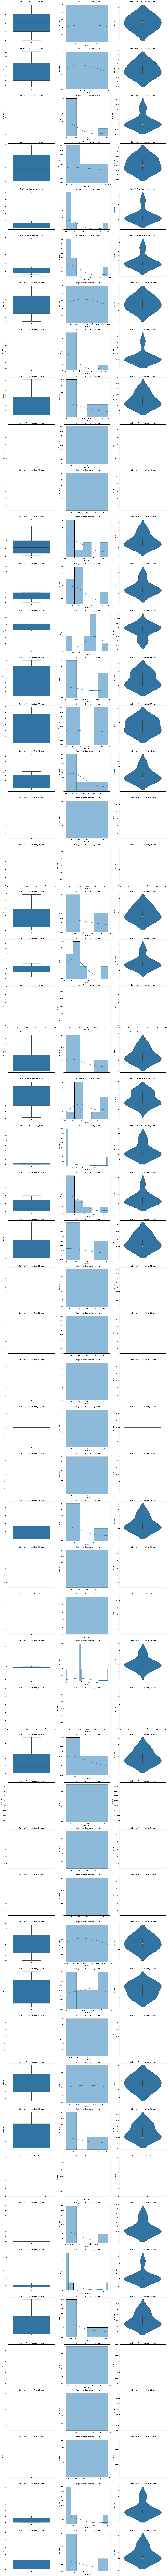

In [ ]:
plot_df_per_document(df_genomic, "cer")

### WER

In [ ]:
plot_df_per_document(df_genomic, "wer")

# To Sum up

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

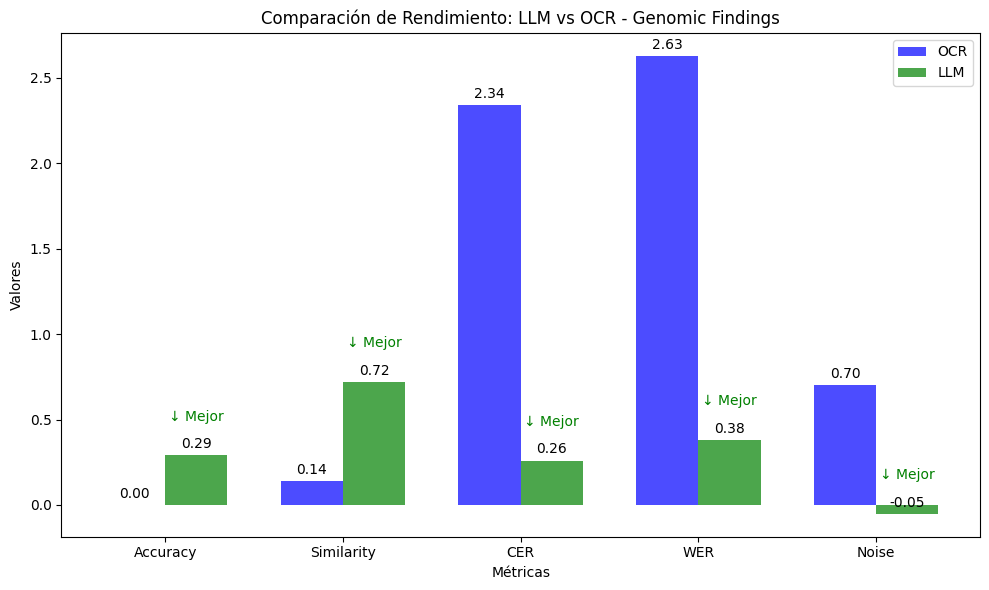

In [ ]:
metrics = ['Accuracy', 'Similarity', 'CER', 'WER', 'Noise']
ocr_values = [0, 0.14, 2.34, 2.63, 0.7017]
llm_values = [0.291, 0.72, 0.26, 0.38, -0.052]
width = 0.35
x = np.arange(len(metrics))

# Crear el gráfico nuevamente con anotaciones personalizadas
fig, ax = plt.subplots(figsize=(10, 6))
bars_ocr = ax.bar(x - width/2, ocr_values, width, label='OCR', color='blue', alpha=0.7)
bars_llm = ax.bar(x + width/2, llm_values, width, label='LLM', color='green', alpha=0.7)

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Rendimiento: LLM vs OCR - Genomic Findings')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir anotaciones de los valores y destacar el mejor enfoque
for bar in bars_ocr:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom')

for i, bar in enumerate(bars_llm):
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom')

    # Anotaciones personalizadas indicando por qué LLM es mejor
    if metrics[i] in ['Accuracy', 'Similarity']:
        ax.annotate('↓ Mejor',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 25),
                    textcoords='offset points',
                    ha='center', color='green', fontsize=10)
    elif metrics[i] in ['CER', 'WER']:
        ax.annotate('↓ Mejor',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 25),
                    textcoords='offset points',
                    ha='center', color='green', fontsize=10)
    elif metrics[i] == 'Noise':
        ax.annotate('↓ Mejor',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 25),
                    textcoords='offset points',
                    ha='center', color='green', fontsize=10)

# Mostrar el gráfico ajustado
plt.tight_layout()
plt.savefig( 'Comparación de Rendimiento: LLM vs OCR - Genomic Findings.png')
plt.show()


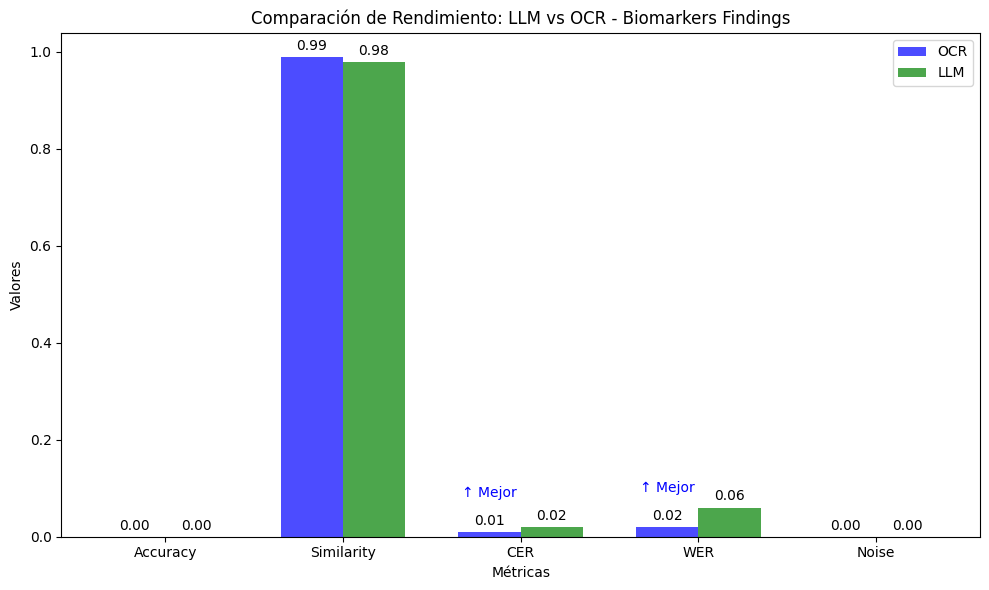

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

metrics = ['Accuracy', 'Similarity', 'CER', 'WER', 'Noise']
ocr_values = [0, 0.99, 0.01, 0.02, 0]
llm_values = [0., 0.98, 0.02, 0.06, 0]

width = 0.35
x = np.arange(len(metrics))

# Crear el gráfico con ajustes
fig, ax = plt.subplots(figsize=(10, 6))
bars_ocr = ax.bar(x - width/2, ocr_values, width, label='OCR', color='blue', alpha=0.7)
bars_llm = ax.bar(x + width/2, llm_values, width, label='LLM', color='green', alpha=0.7)

# Añadir etiquetas, título y leyenda
ax.set_xlabel('Métricas')
ax.set_ylabel('Valores')
ax.set_title('Comparación de Rendimiento: LLM vs OCR - Biomarkers Findings')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Añadir anotaciones de los valores
for bar in bars_ocr:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom')

for i, bar in enumerate(bars_llm):
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # Desplazamiento vertical
                textcoords="offset points",
                ha='center', va='bottom')

    # Anotar únicamente CER y WER destacando OCR como mejor
    if metrics[i] in ['CER', 'WER']:
        ax.annotate('↑ Mejor',
                    xy=(bars_ocr[i].get_x() + bars_ocr[i].get_width() / 2, ocr_values[i]),
                    xytext=(0, 25),
                    textcoords='offset points',
                    ha='center', color='blue', fontsize=10)


# Mostrar el gráfico ajustado
plt.tight_layout()
plt.savefig('Comparación_de_Rendimiento_LLM_vs_OCR_Biomarkers_Findings.png')
plt.show()
